In [1]:
import pandas as pd
import numpy as np
import re
import nltk
import tensorflow.keras as keras
from nltk.corpus import stopwords
import tensorflow as tf

from numpy import array
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras import models, optimizers
from tensorflow.keras import layers
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.layers import Embedding, LSTM
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [3]:
movie_reviews = pd.read_csv("IMDB Dataset.csv")

movie_reviews.isnull().values.any()

movie_reviews.shape

(50000, 2)

In [4]:
movie_reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
movie_reviews["review"][3]

"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."

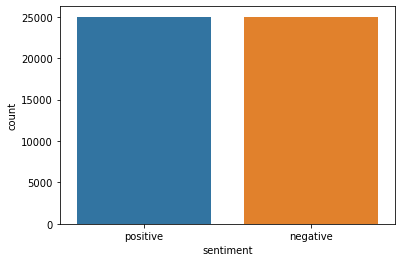

In [6]:
import seaborn as sns

sns.countplot(x='sentiment', data=movie_reviews)

In [7]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence


In [8]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [9]:
X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [10]:
X[3]

'Basically there a family where little boy Jake thinks there a zombie in his closet his parents are fighting all the time This movie is slower than soap opera and suddenly Jake decides to become Rambo and kill the zombie OK first of all when you re going to make film you must Decide if its thriller or drama As drama the movie is watchable Parents are divorcing arguing like in real life And then we have Jake with his closet which totally ruins all the film expected to see BOOGEYMAN similar movie and instead watched drama with some meaningless thriller spots out of just for the well playing parents descent dialogs As for the shots with Jake just ignore them '

In [11]:
y = movie_reviews['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=2)

In [13]:
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [14]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 256

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [15]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
dim = 300
glove_file = open('glove.840B.300d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    x = len(records) - dim
    vector_dimensions = asarray(records[x:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [16]:
embedding_matrix = zeros((vocab_size, dim))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [17]:
def CNN():
    model = Sequential()
    model.add(layers.Embedding(vocab_size, dim, weights=[embedding_matrix], trainable=False, input_length=maxlen))
    model.add(layers.Conv1D(128, 5, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
#     model.compile(optimizer='adam',
#                   loss='binary_crossentropy',
#                   metrics=['accuracy'])
    
    model.compile(optimizer=optimizers.Adam(learning_rate=0.00005),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    model.summary()
    return model

In [18]:
model=CNN()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 256, 300)          27703200  
_________________________________________________________________
conv1d (Conv1D)              (None, 252, 128)          192128    
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                1290      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 27,896,629
Trainable params: 193,429
Non-trainable params: 27,703,200
_________________________________________________________________


In [19]:
history_1 = model.fit(X_train, y_train, batch_size=16, epochs=15, verbose=1, validation_data=(X_test, y_test))

Epoch 1/15
2500/2500 [==============================] - 15s 6ms/step - loss: 0.5236 - accuracy: 0.7570 - val_loss: 0.3766 - val_accuracy: 0.8489
Epoch 2/15
2500/2500 [==============================] - 15s 6ms/step - loss: 0.3371 - accuracy: 0.8602 - val_loss: 0.3217 - val_accuracy: 0.8663
Epoch 3/15
2500/2500 [==============================] - 15s 6ms/step - loss: 0.2904 - accuracy: 0.8805 - val_loss: 0.2964 - val_accuracy: 0.8782
Epoch 4/15
2500/2500 [==============================] - 16s 6ms/step - loss: 0.2599 - accuracy: 0.8955 - val_loss: 0.2852 - val_accuracy: 0.8820
Epoch 5/15
2500/2500 [==============================] - 16s 6ms/step - loss: 0.2350 - accuracy: 0.9082 - val_loss: 0.2770 - val_accuracy: 0.8858
Epoch 6/15
2500/2500 [==============================] - 16s 6ms/step - loss: 0.2124 - accuracy: 0.9182 - val_loss: 0.2732 - val_accuracy: 0.8861
Epoch 7/15
2500/2500 [==============================] - 15s 6ms/step - loss: 0.1910 - accuracy: 0.9295 - val_loss: 0.2688 - val_ac

In [32]:
print("Test Accuracy =", history_1.history["val_accuracy"][14:][0]*100)

Test Accuracy = 89.5799994468689


In [34]:
import matplotlib.pyplot as plt

def plot_score(history):

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])

    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])

    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()

def compare_score(history_1, history_2):

    plt.plot(history_1.history['accuracy'])
    plt.plot(history_2.history['accuracy'])

    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['model 1','model 2'], loc='upper left')
    plt.show()

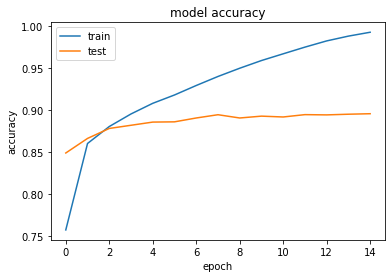

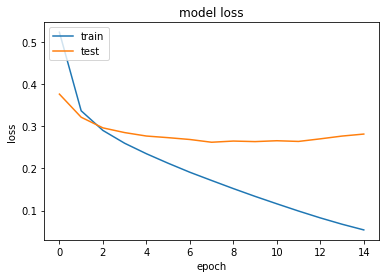

In [35]:
plot_score(history_1)